In [1]:
# tides_analyze.py
#
# Program to analyze SSH vs tide buoys for CNAPS2 verification
#
# Joseph B. Zambon
#  jbzambon@fathomscience.com
#  12 December 2023

In [2]:
# conda create --name isaac_track
# conda activate isaac_track
# conda install jupyter
# conda install -c conda-forge netcdf4
# conda install -c conda-forge matplotlib
# conda install -c conda-forge basemap
# conda install -c conda-forge basemap-data-hires
# pip install noaa_coops

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import numpy as np
import csv
import pandas
import datetime
# get_ipython().magic(u'pylab inline')
%matplotlib inline

In [3]:
from noaa_coops import Station

In [4]:
# Define station
# station_num = '8534720' #Atlantic City, NJ
# station_num = '8771341' #Galveston Bay Entrance, North Jetty, TX
# station_num = '8729210' #Panama City Beach, FL [8729210]
station_num = '8727520' #Cedar Key, FL [8727520]
# station_num = '8726724' #Clearwater Beach, FL [8726724]
# station_num = '8723970' #Vaca Key, Florida Bay, FL [8723970]
# station_num = '8721604' #Trident Pier, Port Canaveral, FL [8721604]
# station_num = '8670870' #Fort Pulaski, GA [8670870]
# station_num = '8665530' #Charleston, SC [8665530]
# station_num = '8651370' #Duck, NC [8651370]
# station_num = '8570283' #Ocean City Inlet, MD [8570283]
# station_num = '8531680' #Sandy Hook, NJ [8531680]
# station_num = '8510560' #Montauk, NY [8510560]
# station_num = '8443970' #Boston, MA [8443970]
# station_num = '8418150' #Portland, ME [8418150]

station = Station(station_num)

print(station.name)
print(station.lat_lon['lon'])
print(station.lat_lon['lat'])
print(station.data_inventory)

Cedar Key
-83.0317
29.135
{'Verified Hourly Height Water Level': {'start_date': '1914-03-13 06:00', 'end_date': '2023-11-30 23:00'}, 'Verified 6-Minute Water Level': {'start_date': '1997-01-02 20:42', 'end_date': '2023-11-30 23:54'}, 'Wind': {'start_date': '2000-02-03 22:00', 'end_date': '2023-12-19 19:00'}, 'Air Temperature': {'start_date': '2000-02-03 22:00', 'end_date': '2023-12-19 19:00'}, 'Verified Monthly Mean Water Level': {'start_date': '1914-04-01 00:00', 'end_date': '2023-11-30 23:54'}, 'Verified High/Low Water Level': {'start_date': '1980-01-01 05:30', 'end_date': '2023-11-30 23:54'}, 'Barometric Pressure': {'start_date': '2000-02-03 22:00', 'end_date': '2023-12-19 19:00'}, 'Water Temperature': {'start_date': '1999-03-31 17:00', 'end_date': '2023-12-19 19:00'}, 'Preliminary 6-Minute Water Level': {'start_date': '2001-01-01 00:00', 'end_date': '2023-12-19 19:00'}}


In [5]:
# Define start/end dates
dstart = '20231024'
dend   = '20231119'

In [6]:
df_water_levels = station.get_data(
...     begin_date=dstart,
...     end_date=dend,
...     product="water_level",
...     datum="MSL",
...     units="metric",
...     time_zone="gmt")
df_water_levels.head()

,v,s,f,q
t,,,,
2023-10-24 00:00:00,0.155,0.002,"0,0,0,0",v
2023-10-24 00:06:00,0.173,0.003,"0,0,0,0",v
2023-10-24 00:12:00,0.192,0.003,"0,0,0,0",v
2023-10-24 00:18:00,0.212,0.003,"0,0,0,0",v
2023-10-24 00:24:00,0.230,0.003,"0,0,0,0",v


In [7]:
# Put buoy data into numpy array
buoy_time = df_water_levels.index.to_numpy(dtype="datetime64[ns]")
buoy_mllw = df_water_levels[['v']].to_numpy()

In [8]:
# Load NetCDF data
combined_file = '/Users/jbzambon/Downloads/combined.nc'
roms_qck = Dataset(combined_file,'r')
lat = np.array(roms_qck.variables['lat_rho'][:,:])
lon = np.array(roms_qck.variables['lon_rho'][:,:])

In [9]:
def findxy_model(lon1,lat1,lon,lat):
    dis=np.sqrt(np.square(np.subtract(lon,lon1))+np.square(np.subtract(lat,lat1)))
    from numpy import unravel_index
    index=unravel_index(dis.argmin(), dis.shape)
    jj=index[0]
    ii=index[1]
    jj=int(jj)
    ii=int(ii)
    return jj,ii

In [10]:
[jj,ii] = findxy_model(station.lat_lon['lon'],station.lat_lon['lat'],lon,lat)
print('Model jj, ii points: ', jj,ii)

Model jj, ii points:  423 374


In [11]:
zeta = np.array(roms_qck.variables['zeta'][:,jj,ii])
time = np.array(roms_qck.variables['ocean_time'][:])
cleantime = time / 86400

In [12]:
roms_time=[]
for t in np.arange(0,np.size(cleantime[:])):
    roms_time.append(datetime.datetime(1858,11,17)+datetime.timedelta(days=cleantime[t]))

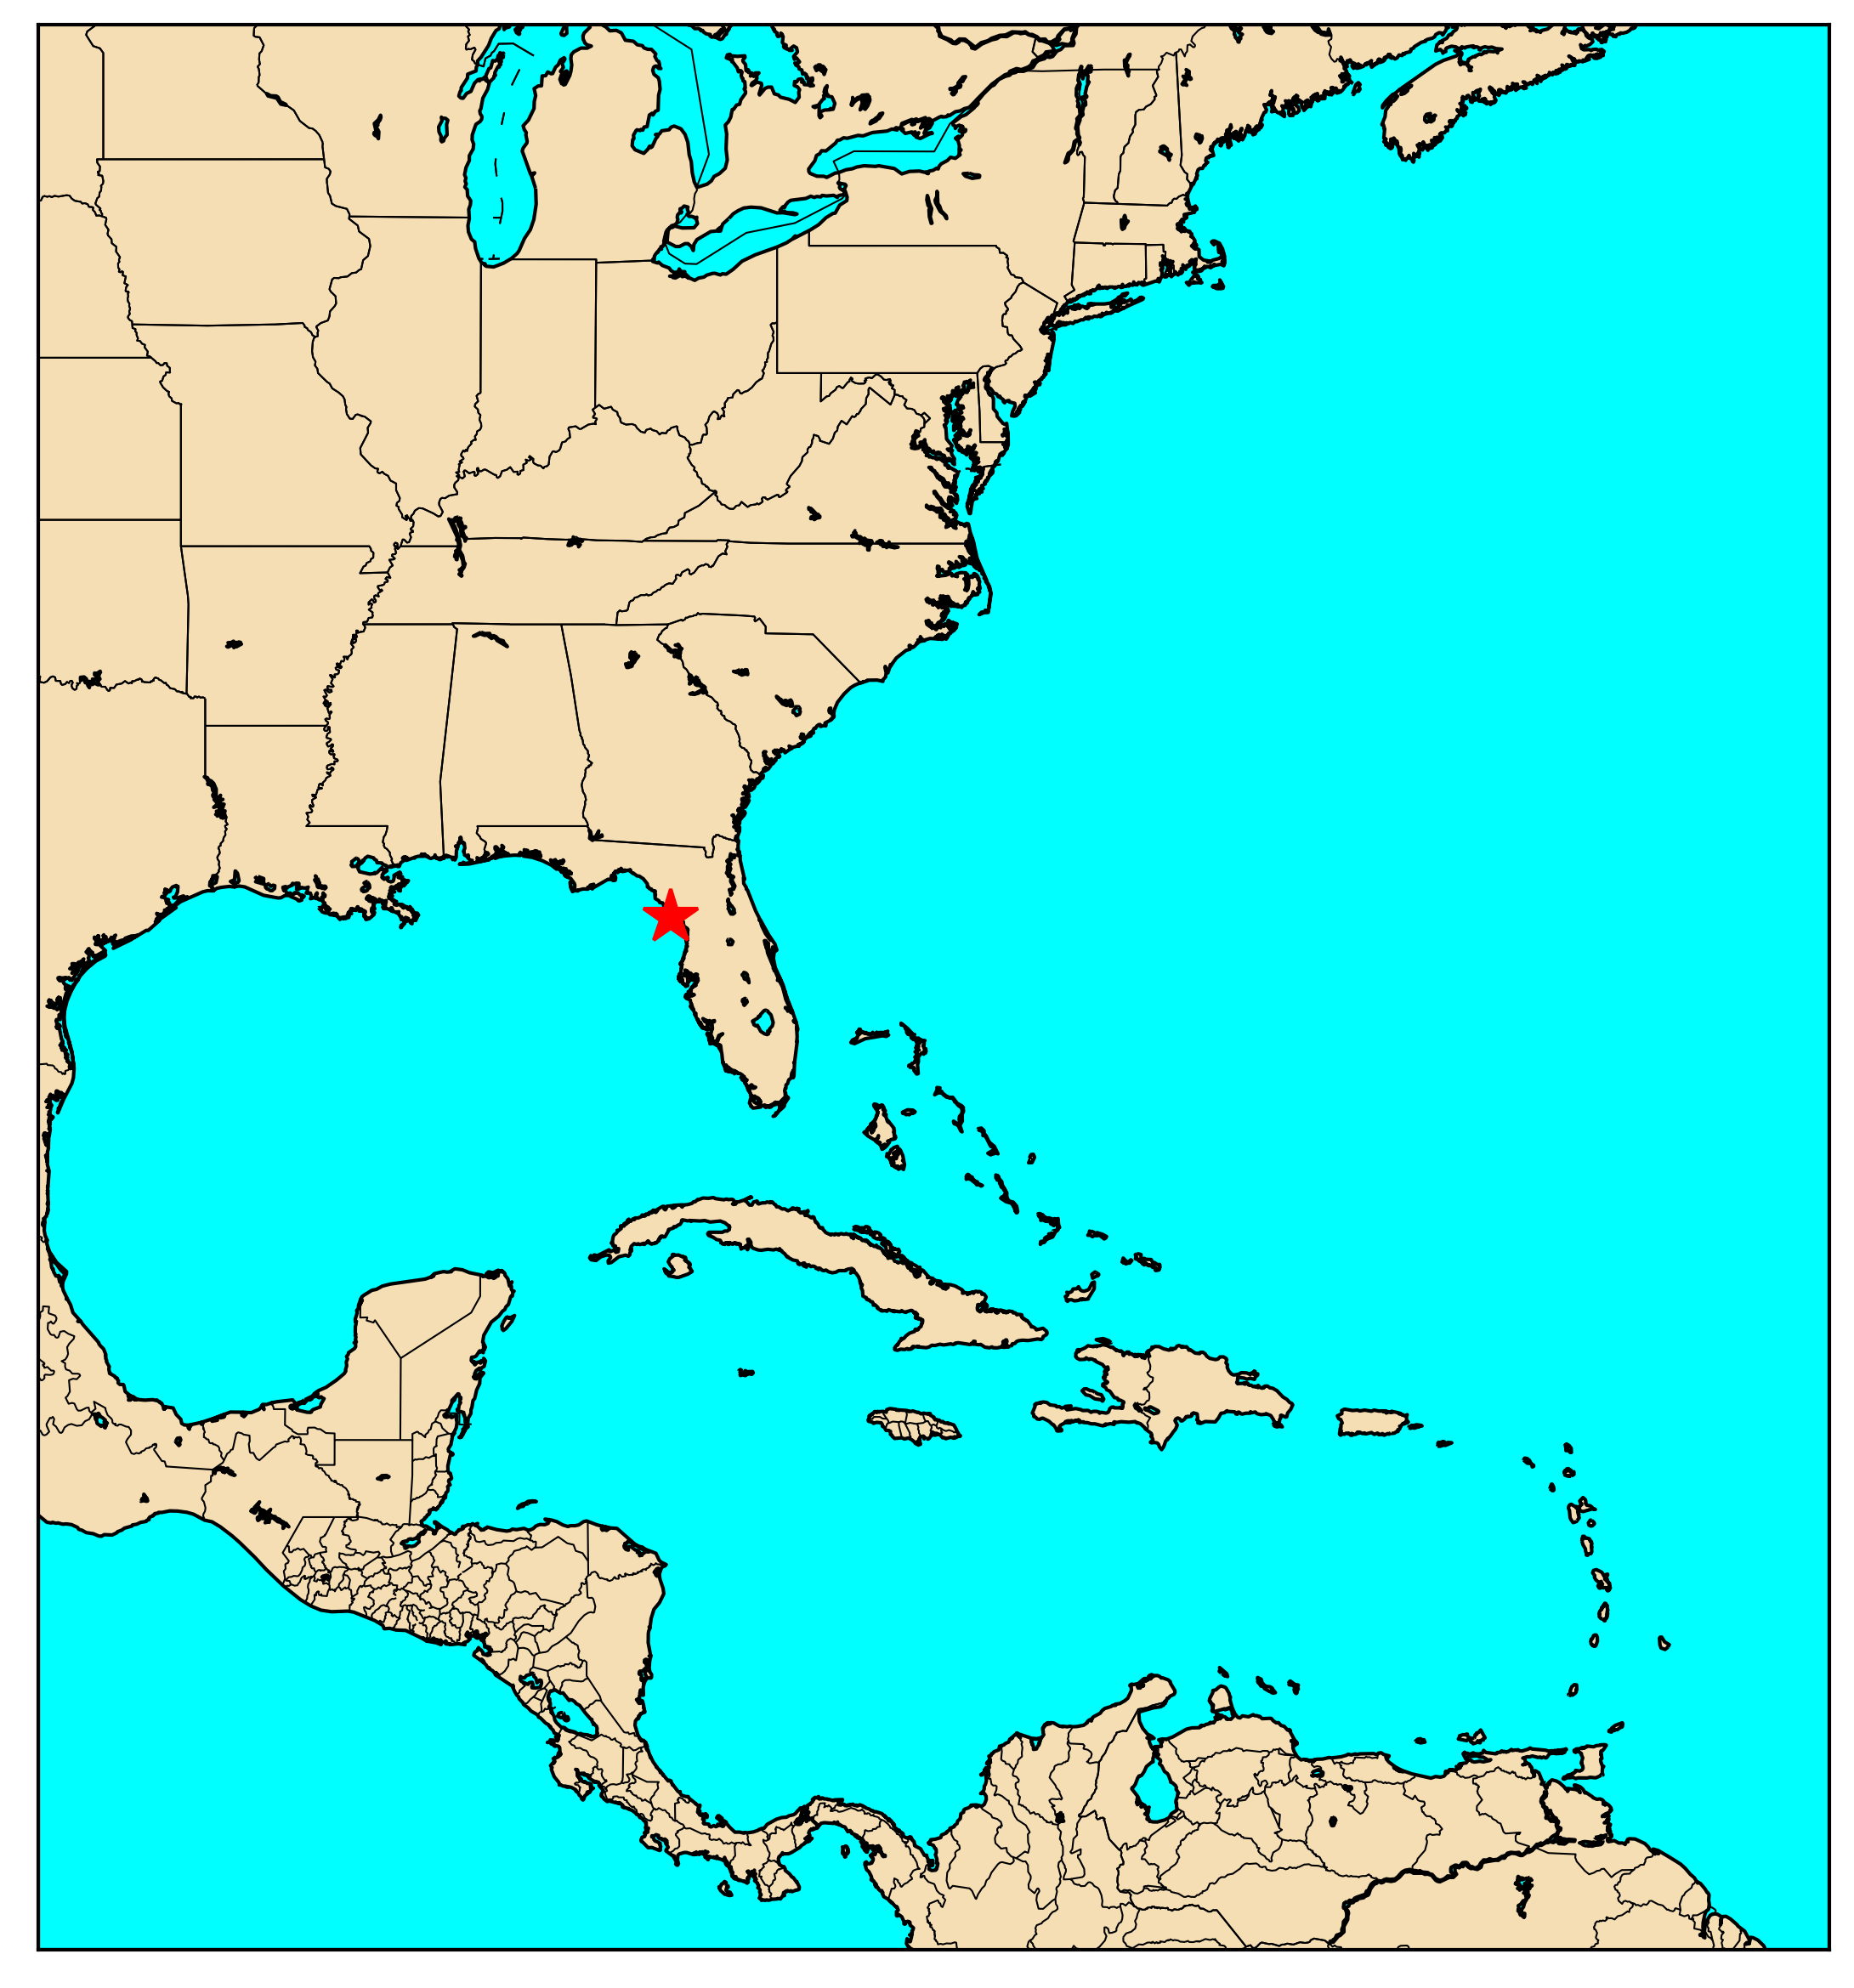

In [13]:
# Plot station location

fig1=plt.figure(figsize=(15,10),dpi=300)
map = Basemap(projection='merc',
    resolution='i',lat_0=((np.max(lat)-np.min(lat))/2),
    lon_0=((np.max(lon)-np.min(lon))/2),
    llcrnrlon=np.min(lon),llcrnrlat=np.min(lat),
    urcrnrlon=np.max(lon),urcrnrlat=np.max(lat))
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='wheat',lake_color='aqua')
map.drawcoastlines()
map.drawcountries()
map.drawstates()
x_loc,y_loc = map(station.lat_lon['lon'],station.lat_lon['lat'])
map.plot(x_loc,y_loc, 'r*', markersize=16)
plt.savefig(str(station_num) + '_map.png')

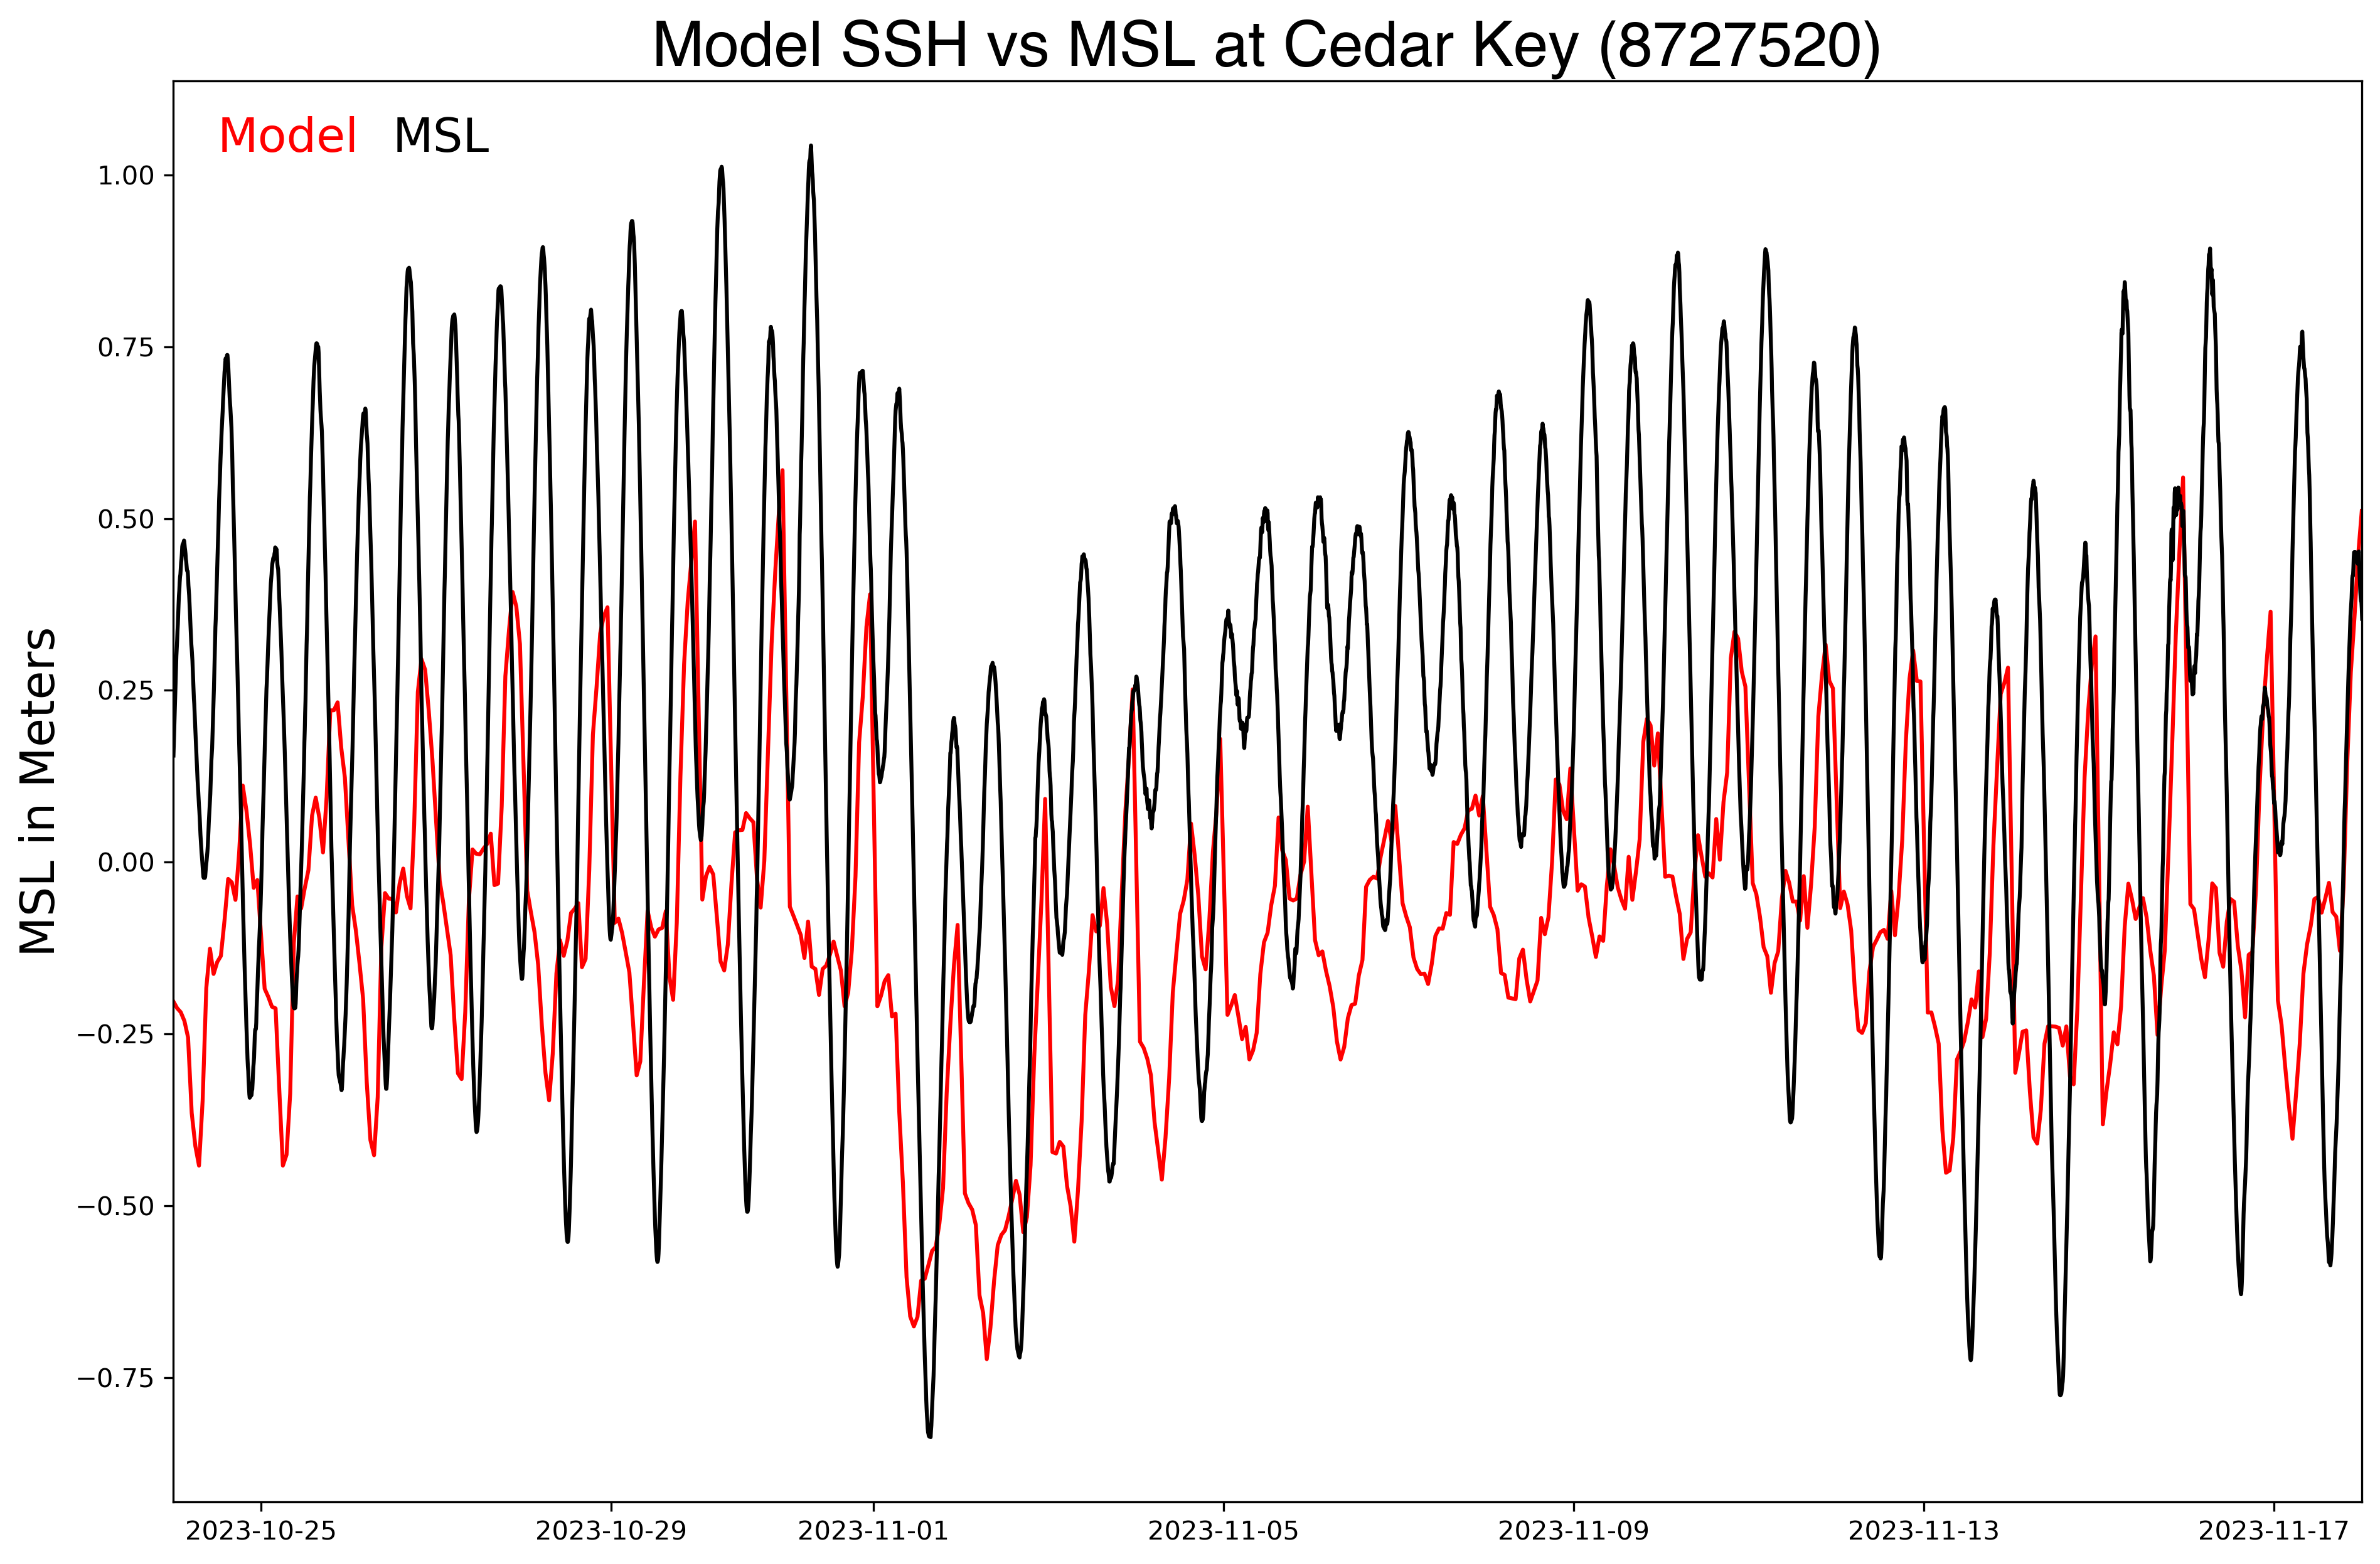

In [14]:
# Plot timeseries

fig1, ax=plt.subplots(figsize=(15,10),dpi=300)
plt.title(('Model SSH vs MSL at ' + station.name + " (" + station_num + ")"),fontsize=24,family='Helvetica')
plt.plot(roms_time,zeta,'r')
plt.plot(buoy_time,buoy_mllw,'k')
ax.set_ylabel('MSL in Meters',fontsize=18)
plt.xlim(roms_time[0],roms_time[-1])
plt.annotate('Model', xy=(0.02, 0.95), xycoords='axes fraction',color='r',fontsize=18)
plt.annotate('MSL', xy=(0.1, 0.95), xycoords='axes fraction',color='k',fontsize=18)
plt.savefig(str(station_num) + '_timeseries.png')

In [34]:
#Haibo's means
import scipy.io
mat_file = '/Users/jbzambon/Desktop/msl_difference_longterm.mat'
matfile = scipy.io.loadmat(mat_file,squeeze_me=True)
msl_diff = matfile['msl_difference']
stations = matfile['stations']

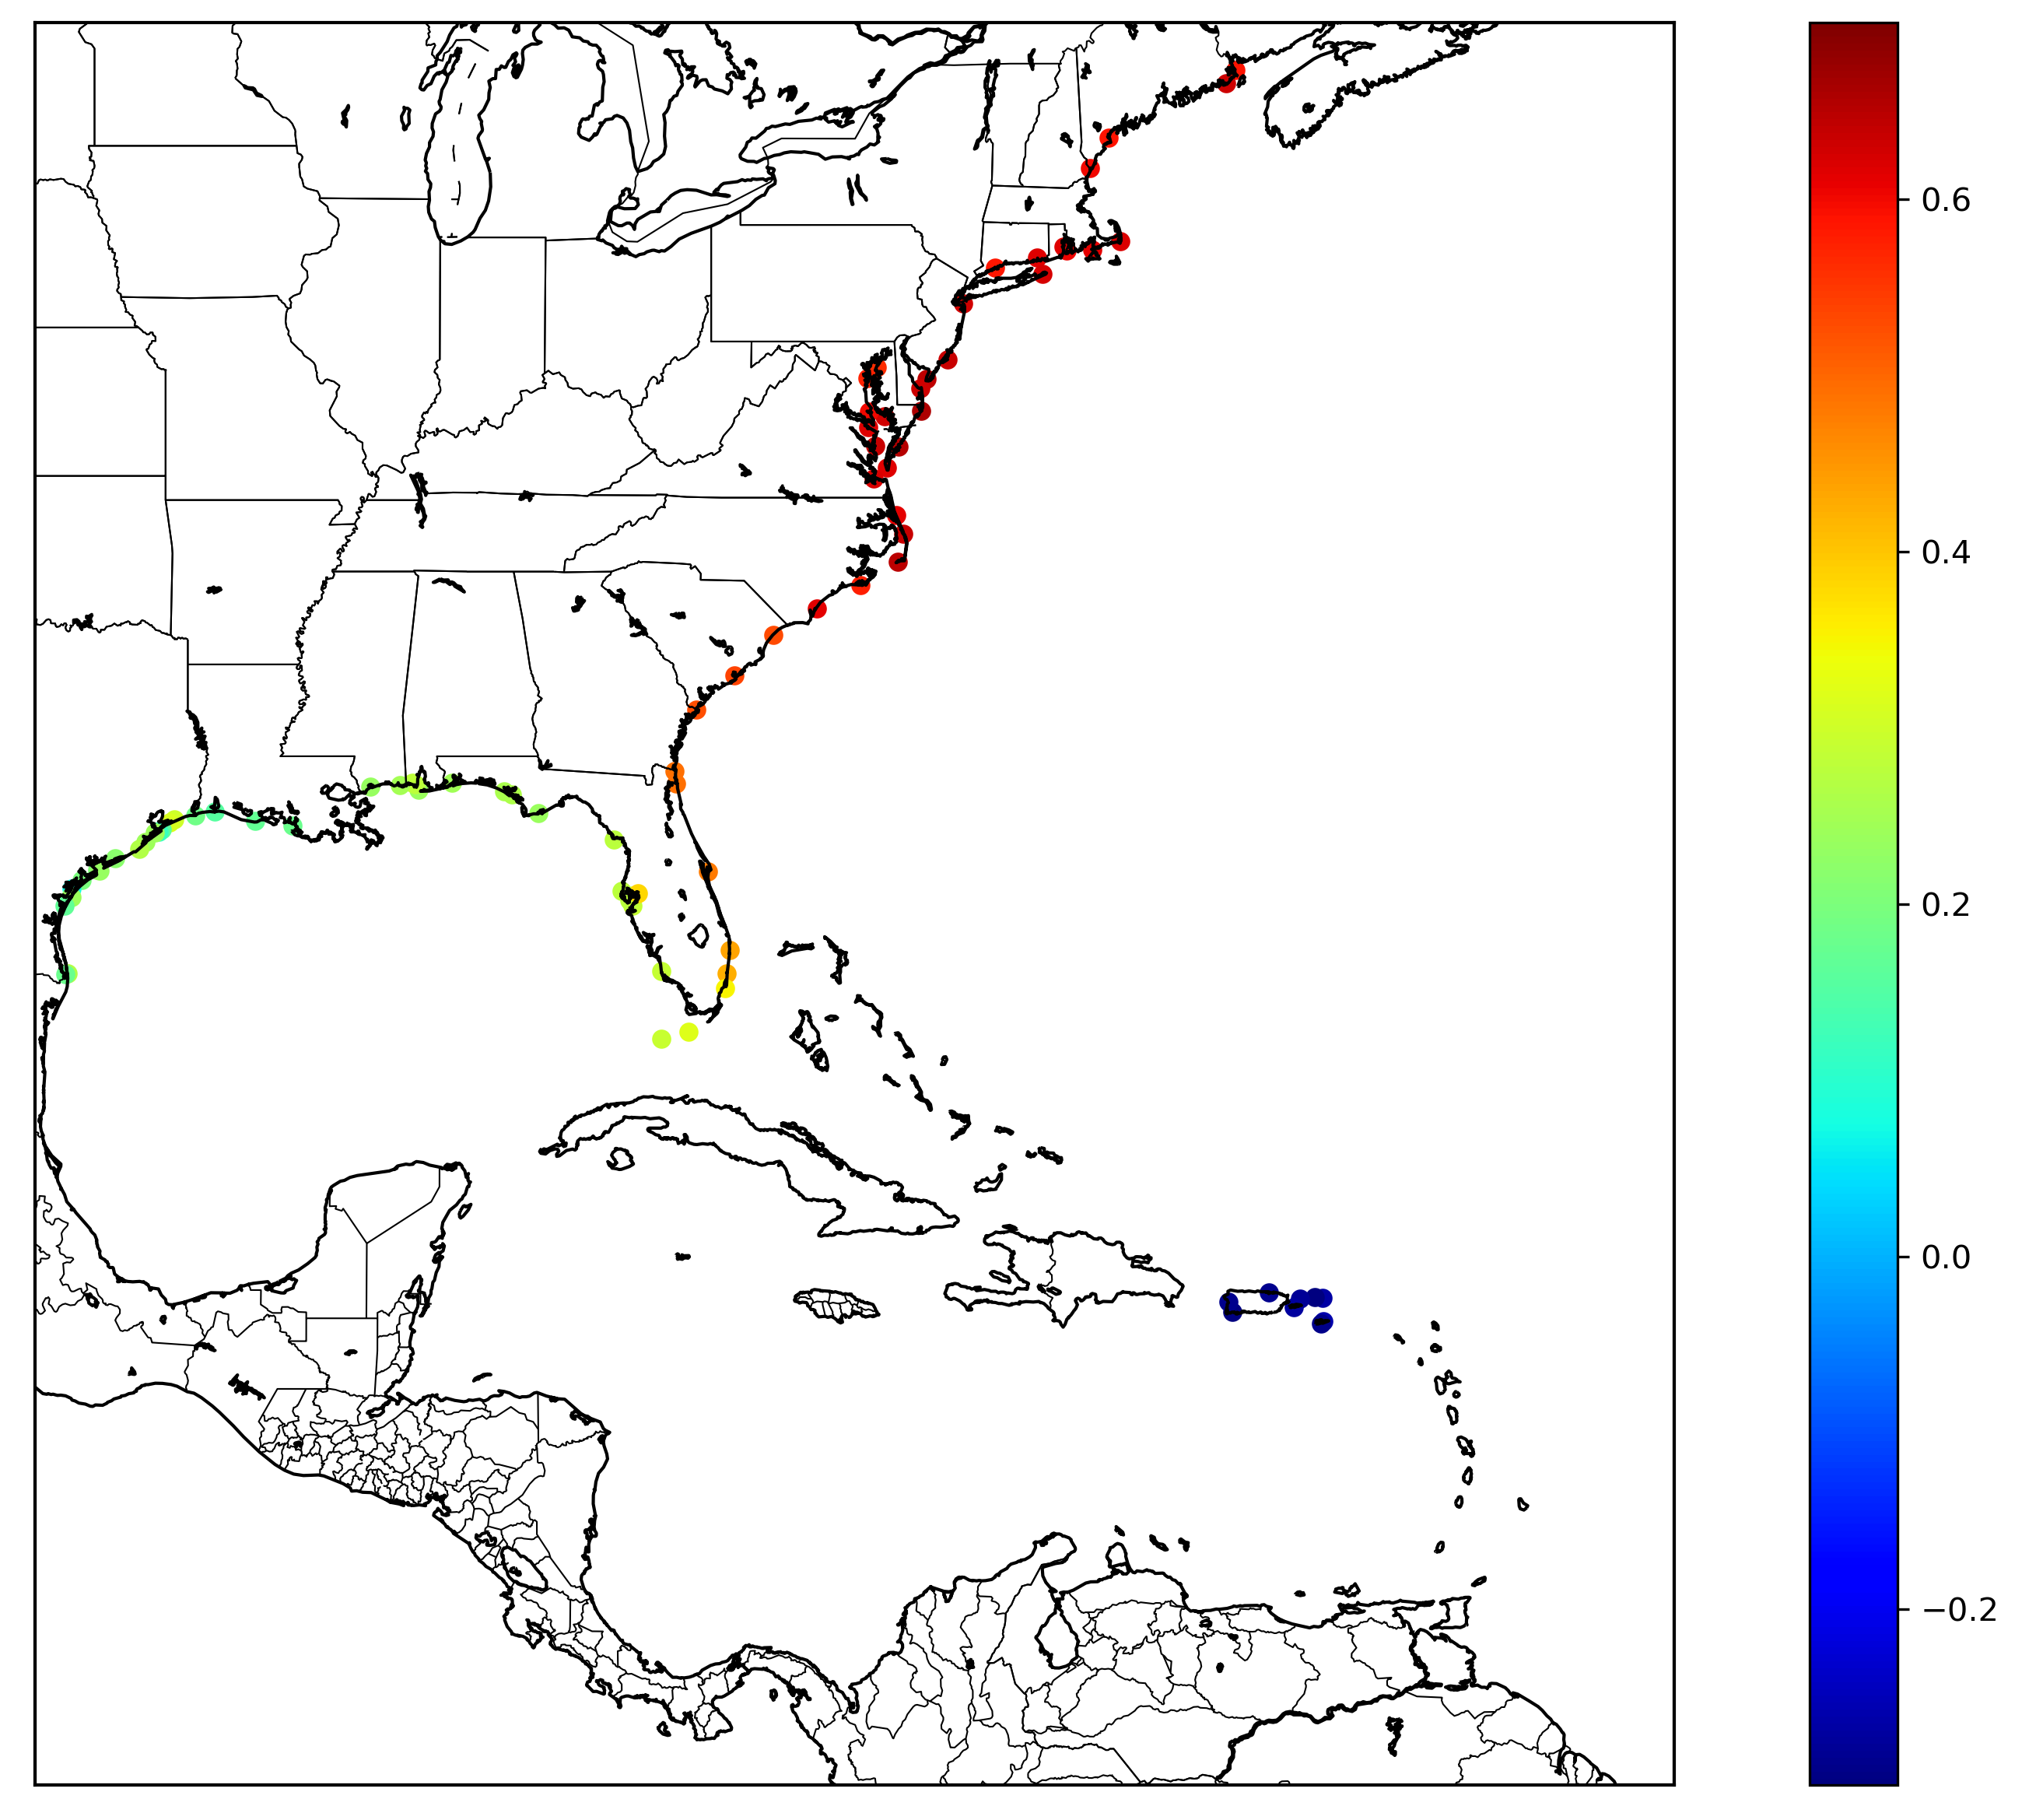

In [76]:
station = Station(stations[0])

# Plot station location

fig1=plt.figure(figsize=(15,10),dpi=300)
map = Basemap(projection='merc',
    resolution='i',lat_0=((np.max(lat)-np.min(lat))/2),
    lon_0=((np.max(lon)-np.min(lon))/2),
    llcrnrlon=np.min(lon),llcrnrlat=np.min(lat),
    urcrnrlon=np.max(lon),urcrnrlat=np.max(lat))
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
map.drawcoastlines()
map.drawcountries()
map.drawstates()
for dot in np.arange(0,stations.shape[0]):
# for dot in np.arange(80,82):
    x_loc,y_loc=map(Station(stations[dot]).lat_lon['lon'],Station(stations[dot]).lat_lon['lat'])
    map.scatter(x_loc,y_loc,cmap='jet',marker='o',c=msl_diff[dot],s=24,vmin=-0.3,vmax=0.7)
#     map.scatter(x_loc,y_loc,cmap='jet',marker='o',c='k',s=24)
cbar=plt.colorbar()
plt.savefig('msldiff_map.png',facecolor='white', transparent=False)

In [77]:
plt.savefig('msldiff_map.png',facecolor='white', transparent=False)

<Figure size 432x288 with 0 Axes>

In [78]:
np.max(msl_diff)

0.6575607525225311

In [79]:
np.min(msl_diff)

-0.32865056015832084